In [10]:
import pandas as pd
import numpy as np
import re
import itertools
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix
from sklearn.model_selection import GridSearchCV
import random

In [75]:
# Just get a basic view of the text and related sentiment
df = pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## Some graphs give basic thoughts

Text(0.5, 1.0, 'Count of Sentiment')

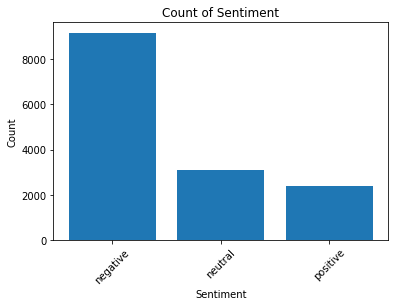

In [76]:
sentiment_count = df['airline_sentiment'].value_counts()
Index = [1,2,3]
plt.bar(Index, sentiment_count)
plt.xticks(Index,['negative','neutral','positive'], rotation = 45)
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.title('Count of Sentiment')

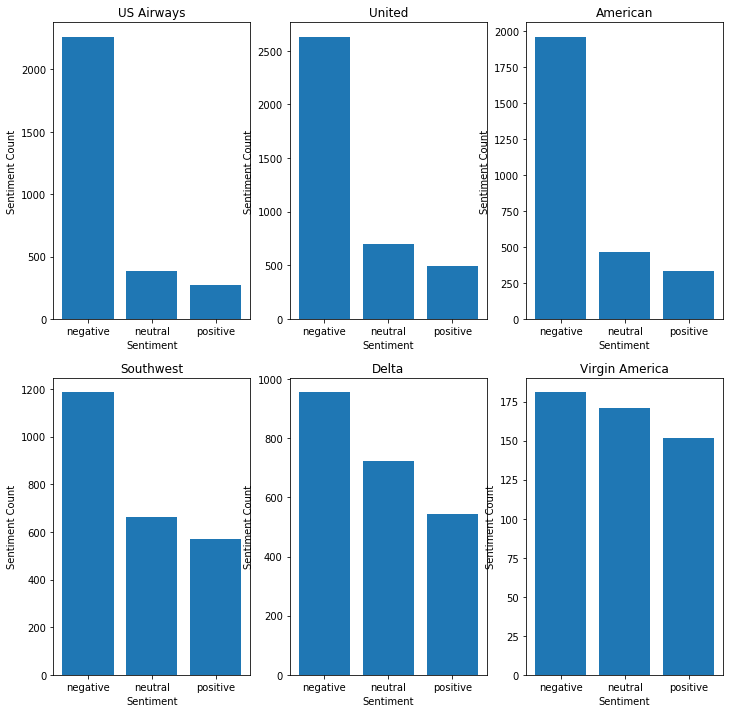

In [77]:
def plot_sub_sentiment(Airline):
    data_frame = df[df['airline'] == Airline]
    count = data_frame['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count)
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Sentiment Count')
    plt.xlabel('Sentiment')
    plt.title(Airline)

plt.figure(1,figsize=(12, 12))
plt.subplot(231)
plot_sub_sentiment('US Airways')
plt.subplot(232)
plot_sub_sentiment('United')
plt.subplot(233)
plot_sub_sentiment('American')
plt.subplot(234)
plot_sub_sentiment('Southwest')
plt.subplot(235)
plot_sub_sentiment('Delta')
plt.subplot(236)
plot_sub_sentiment('Virgin America')

In [78]:
NR_Count = dict(df['negativereason'].value_counts())

In [79]:
def NR_Count(Airline):
    if Airline=='All':
        table = df
    else:
        table = df[df['airline'] == Airline]
    count = dict(table['negativereason'].value_counts())
    Unique_reason = list(df['negativereason'].unique())
    Unique_reason = [x for x in Unique_reason if str(x) != 'nan']
    Reason_frame = pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count'] = Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame

In [80]:
NR_Count('Delta')

,Reasons,count
0,Bad Flight,64
1,Can't Tell,186
2,Late Flight,269
3,Customer Service Issue,199
4,Flight Booking Problems,44
5,Lost Luggage,57
6,Flight Attendant Complaints,60
7,Cancelled Flight,51
8,Damaged Luggage,11
9,longlines,14


In [81]:
def plot_reason(Airline):
    df = NR_Count(Airline)
    count = df['count']
    Index = range(1,(len(df)+1))
    plt.bar(Index,count)
    plt.xticks(Index,df['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)

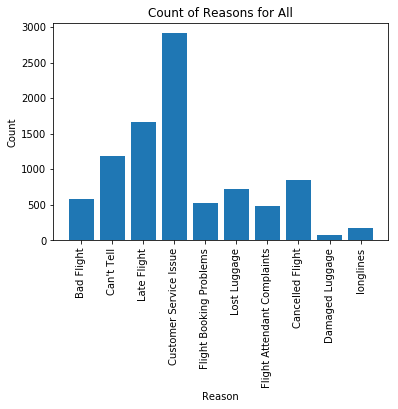

In [82]:
plot_reason('All')

In [83]:
df_negative = df[df['airline_sentiment'] == 'negative']
words = ' '.join(df_negative['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'])

In [86]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500).generate(cleaned_word)

(-0.5, 2999.5, 2499.5, -0.5)

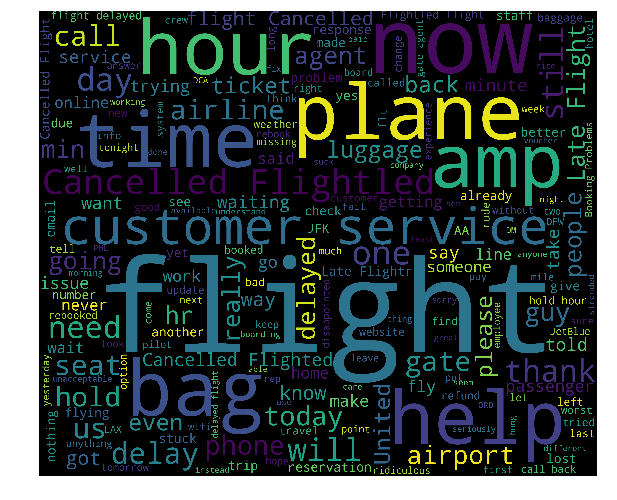

In [87]:
plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')

## Clean the table

In [2]:
# Just show the text and corresponding sentiment

df = pd.read_csv('Tweets.csv')
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]
df.head()

,text,airline_sentiment
12842,@AmericanAir yes I did but no response.,negative
4572,@SouthwestAir any word when the customer relat...,neutral
1399,@united On top of that I paid for 1st class an...,negative
4652,@SouthwestAir but when do I get my gin &amp; t...,negative
14175,@AmericanAir understand the weather but would ...,negative


In [3]:
# Some functions I used in the preprocessing

def remove_stopwords(text):
    stopwords_list = stopwords.words('english')
    whitelist = ["n't", "not", "no"]
    words = text.split() 
    clean_words = [word.lower() for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 

def extra_clean(text):
    remove_mention = re.sub(r'@\w+', '', text)
    remove_url = re.sub('https?://[A-Za-z0-9./]+', '', remove_mention)
    remove_hashtag = re.sub("[^a-zA-Z]", " ", remove_url)
    
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', remove_hashtag)

def convert_sentiment(sentiment):
    return 1 if sentiment=='negative' else 0

In [4]:
df.text = df.text.apply(remove_stopwords).apply(extra_clean)
df.head()

,text,airline_sentiment
12842,yes no response,negative
4572,word customer relations department open back up,neutral
1399,on top paid st class wife got stuck coach,negative
4652,get gin amp tonic,negative
14175,understand weather would nice hear apology ph...,negative


In [5]:
df.airline_sentiment = df.airline_sentiment.apply(convert_sentiment)
df.head()

,text,airline_sentiment
12842,yes no response,1
4572,word customer relations department open back up,0
1399,on top paid st class wife got stuck coach,1
4652,get gin amp tonic,1
14175,understand weather would nice hear apology ph...,1


In [6]:
# Split the data into training and test set by the ratio 8:2

X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.2, random_state=37)
print('Train data samples:', X_train.shape[0])
print('Test data samples:', X_test.shape[0])

Train data samples: 11712
Test data samples: 2928


In [7]:
vectorizer_tf = TfidfVectorizer(ngram_range = (1,2))
vectorizer_tf.fit(X_train)
Tfvector_train = vectorizer_tf.transform(X_train)
Tfvector_test = vectorizer_tf.transform(X_test)

# Logistic Regression

In [209]:
grid = {"C":np.logspace(-5,2,10), "penalty":["l1","l2"]}
logreg = LogisticRegression()
logreg_cv=  GridSearchCV(logreg, grid, cv = 10)
logreg_cv.fit(Tfvector_train, y_train)

print("tuned hpyerparameters :(best parameters) ", logreg_cv.best_params_)
best_c = logreg_cv.best_params_['C']
best_penalty = logreg_cv.best_params_['penalty']

C:\Users\sheny\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sheny\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


tuned hpyerparameters :(best parameters)  {'C': 16.68100537200059, 'penalty': 'l2'}


The final AUC is 0.9067896994435606


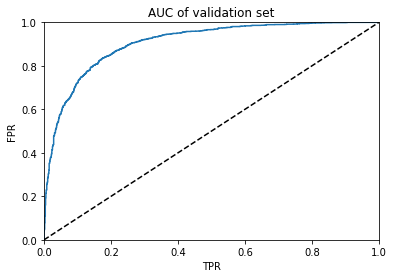

In [210]:
LR = LogisticRegression(penalty=best_penalty, C=best_c)
LR.fit(Tfvector_train, y_train)
predict_result = LR.predict(Tfvector_test)

lr_tpr,lr_fpr,_ = roc_curve(y_test, LR.predict_proba(Tfvector_test)[:,1])
lr_auc = roc_auc_score(y_test, LR.predict_proba(Tfvector_test)[:,1])
plt.plot(lr_tpr,lr_fpr)
plt.xlabel('TPR')
plt.ylabel('FPR')
plt.title('AUC of validation set')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
print('The final AUC is {}'.format(lr_auc))

In [11]:
def plot_confusion_matrix(cm, title, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

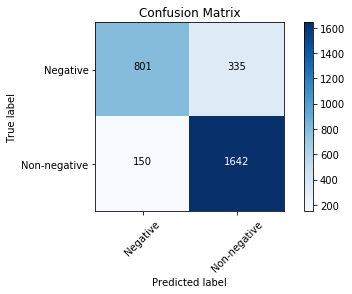

In [168]:
cnf_matrix = confusion_matrix(y_test, predict_result)
plt.figure()
plot_confusion_matrix(cnf_matrix, title="Confusion Matrix", classes=["Negative", "Non-negative"])
plt.show()

# Application

In [169]:
print('The negative seniment predicted in the future: {}'.format(list(predict_result).count(1)))

The negative seniment predicted in the future: 1977


In [243]:
example = Tfvector_test[random.randint(1,Tfvector_test.shape[0]+1)]
pre = LR.predict_proba(example)
print('The likelihood of negative seniment : {0:3f}'.format(pre[0][0]))

The likelihood of negative seniment : 0.589228


# SVM

In [15]:
grid = {"C":np.logspace(-5,2,4), "kernel":['linear', 'rbf']}
svm = SVC()
svm_cv=  GridSearchCV(svm, grid, cv = 5)
svm_cv.fit(Tfvector_train, y_train)

print("tuned hpyerparameters :(best parameters) ", svm_cv.best_params_)
best_c = svm_cv.best_params_['C']
best_kernel = svm_cv.best_params_['kernel']

C:\Users\sheny\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


tuned hpyerparameters :(best parameters)  {'C': 100.0, 'kernel': 'linear'}


The final AUC is 0.9010256836212799


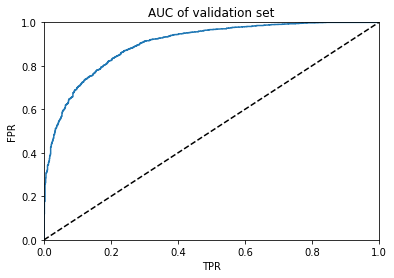

In [16]:
SVM = SVC(C=100, kernel='linear')
SVM.fit(Tfvector_train, y_train)
predict_result = SVM.predict(Tfvector_test)

svm_tpr,svm_fpr,_ = roc_curve(y_test, SVM.decision_function(Tfvector_test))
svm_auc = roc_auc_score(y_test, SVM.decision_function(Tfvector_test))
plt.plot(svm_tpr,svm_fpr)
plt.xlabel('TPR')
plt.ylabel('FPR')
plt.title('AUC of validation set')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
print('The final AUC is {}'.format(svm_auc))

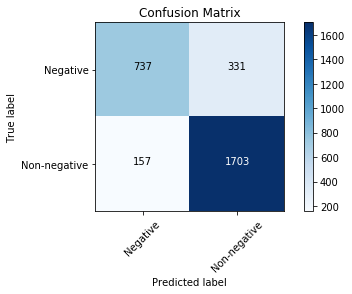

In [17]:
cnf_matrix = confusion_matrix(y_test, predict_result)
plt.figure()
plot_confusion_matrix(cnf_matrix, title="Confusion Matrix", classes=["Negative", "Non-negative"])
plt.show()

# Random Forest

In [ ]:
rfc = RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [600, 800],
    'max_features': ['auto','sqrt', 'log2'],
    'max_depth' : [500,600],
    'criterion' :['gini', 'entropy']}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
CV_rfc.fit(Tfvector_train, y_train)

print("tuned hpyerparameters :(best parameters) ", CV_rfc.best_params_)

The final AUC is 0.88794626676332


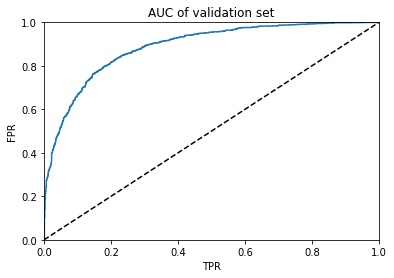

In [8]:
RF = RandomForestClassifier(n_estimators=600, max_features='auto', max_depth=500, criterion='gini')
RF.fit(Tfvector_train, y_train)
predict_result = RF.predict(Tfvector_test)

rf_tpr,rf_fpr,_ = roc_curve(y_test, RF.predict_proba(Tfvector_test)[:,1])
rf_auc = roc_auc_score(y_test, RF.predict_proba(Tfvector_test)[:,1])
plt.plot(rf_tpr,rf_fpr)
plt.xlabel('TPR')
plt.ylabel('FPR')
plt.title('AUC of validation set')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
print('The final AUC is {}'.format(rf_auc))

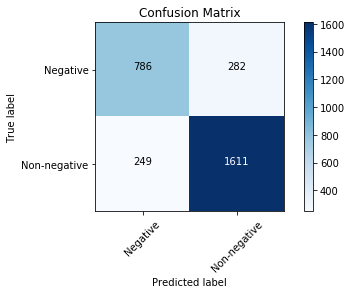

In [12]:
cnf_matrix = confusion_matrix(y_test, predict_result)
plt.figure()
plot_confusion_matrix(cnf_matrix, title="Confusion Matrix", classes=["Negative", "Non-negative"])
plt.show()

# Feature table

In [99]:
dt_model = tree.DecisionTreeClassifier().fit(Tfvector_train, y_train)
predict_result = dt_model.predict(Tfvector_test)

correct_count = 0
for i, s in enumerate(predict_result):
    if s == y_test.iloc[i]:
        correct_count += 1
print('accuracy is {}'.format(correct_count/len(y_test)))
print('The negative seniment predicted in the future: {}'.format(list(predict_result).count(1)))

accuracy is 0.7568306010928961
The negative seniment predicted in the future: 1786


Text(0.5, 1.0, 'feature analysis')

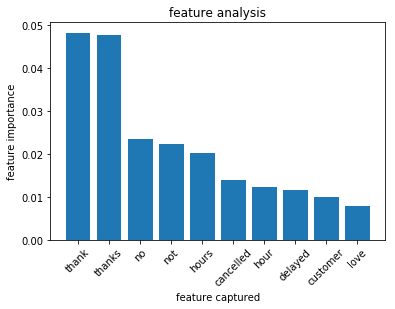

In [100]:
feature_importance = np.sort(dt_model.feature_importances_)[::-1]
tentop_feature = feature_importance[:10]
feature_list = [i for i in dt_model.feature_importances_]
feature_name = [vectorizer_tf.get_feature_names()[feature_list.index(f)] for f in tentop_feature]

Index = [i for i in range(1,11)]
plt.bar(Index, tentop_feature)
plt.xticks(Index,feature_name, rotation = 45)
plt.xlabel('feature captured')
plt.ylabel('feature importance')
plt.title('feature analysis')

# Delta example

In [246]:
df = pd.read_csv('Tweets.csv')
delta_df = df[df['airline']=='Delta']
delta_df = delta_df.reindex(np.random.permutation(delta_df.index))  
delta_df = delta_df[['text', 'airline_sentiment']]
delta_df.head()

,text,airline_sentiment
6881,“@JetBlue: Our fleet's on fleek. http://t.co/V...,neutral
7137,“@JetBlue: Our fleet's on fleek. http://t.co/y...,negative
8164,@JetBlue 108 to Portland Maine,neutral
7286,@JetBlue i only take jetblue to travel and i h...,negative
8704,"@JetBlue Clients got ZERO, in 32 years career ...",negative


In [247]:
delta_df.text = delta_df.text.apply(remove_stopwords).apply(extra_clean)
delta_df.airline_sentiment = delta_df.airline_sentiment.apply(convert_sentiment)
delta_df.head()

,text,airline_sentiment
6881,our fleet s fleek happened,0
7137,our fleet s fleek really jetblue fleek...,1
8164,portland maine,0
7286,take jetblue travel go maimi next year guys d...,1
8704,clients got zero years career never thoug...,1


In [249]:
X_train, X_test, y_train, y_test = train_test_split(delta_df.text, delta_df.airline_sentiment, test_size=0.1, random_state=37)
print('Train data samples:', X_train.shape[0])
print('Test data samples:', X_test.shape[0])

vectorizer_tf = TfidfVectorizer(ngram_range = (1,2))
vectorizer_tf.fit(X_train)
Tfvector_train = vectorizer_tf.transform(X_train)
Tfvector_test = vectorizer_tf.transform(X_test)

Train data samples: 1999
Test data samples: 223


Text(0.5, 1.0, 'Feature Analysis for Delta')

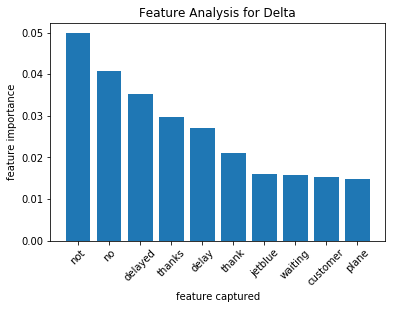

In [251]:
dt_model = tree.DecisionTreeClassifier().fit(Tfvector_train, y_train)
predict_result = dt_model.predict(Tfvector_test)

feature_importance = np.sort(dt_model.feature_importances_)[::-1]
tentop_feature = feature_importance[:10]
feature_list = [i for i in dt_model.feature_importances_]
feature_name = [vectorizer_tf.get_feature_names()[feature_list.index(f)] for f in tentop_feature]

Index = [i for i in range(1,11)]
plt.bar(Index, tentop_feature)
plt.xticks(Index,feature_name, rotation = 45)
plt.xlabel('feature captured')
plt.ylabel('feature importance')
plt.title('Feature Analysis for Delta')